In [5]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)
from scipy.spatial import cKDTree
from math import *
np.random.seed(123)
import urllib.request
import urllib, os

In [6]:
import pandas as pd
import xarray as xr
import math
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

In [7]:
import numpy as np
import xarray as xr
import xesmf as xe

In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [9]:
ds = xr.open_dataset(r'/home/shubham/ugp/cl_new/Grace_2002-2021.nc')

In [10]:
month_length = ds.time.dt.days_in_month
month_length

<xarray.DataArray 'days_in_month' (time: 236)>
array([30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31,
       30, 31, 30, 31, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31,
       28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30,
       31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30,
       31, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30,
       31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30,
       31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 29,
       31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31,
       31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
       31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31, 30, 31,
       30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
       30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31,
       30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30, 31, 31,
       30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30])
Coordinates:
  * time     (time) datetime64[ns] 2002-04-01 2002-05-01 ... 2021-11-01

In [11]:
# Calculate the weights by grouping by 'time.season'.
weights = (
    month_length.groupby("time.season") / month_length.groupby("time.season").sum()
)

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted = (ds * weights).groupby("time.season").sum(dim="time")

In [12]:
ds_weighted

<xarray.Dataset>
Dimensions:        (x: 360, y: 180, season: 4)
Coordinates:
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * y              (y) float64 -90.0 -89.0 -88.0 -87.0 ... 86.0 87.0 88.0 89.0
  * season         (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    lwe_thickness  (season, y, x) float64 0.0 0.0 0.0 0.0 ... 2.096 2.096 2.096

In [13]:
# only used for comparisons
ds_unweighted = ds.groupby("time.season").mean("time")
ds_diff = ds_weighted - ds_unweighted

Text(0.5, 1.02, 'Seasonal Liquid Water Equivalent thickness')

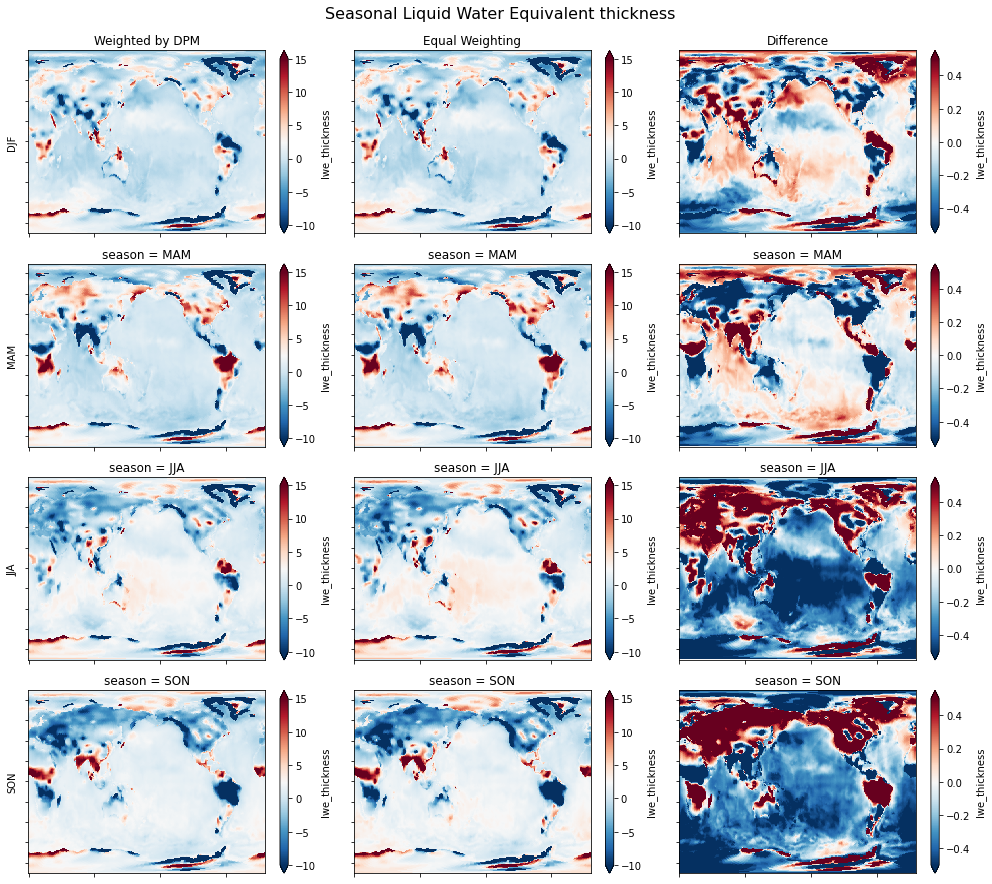

In [14]:
# Quick plot to show the results
notnull = pd.notnull(ds_unweighted["lwe_thickness"][0])

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14, 12))
for i, season in enumerate(("DJF", "MAM", "JJA", "SON")):
    ds_weighted["lwe_thickness"].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 0],
        vmin=-10,
        vmax=15,
        cmap="RdBu_r",
        add_colorbar=True,
        extend="both",
    )

    ds_unweighted["lwe_thickness"].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 1],
        vmin=-10,
        vmax=15,
        cmap="RdBu_r",
        add_colorbar=True,
        extend="both",
    )

    ds_diff["lwe_thickness"].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 2],
        vmin=-0.5,
        vmax=0.5,
        cmap="RdBu_r",
        add_colorbar=True,
        extend="both",
    )

    axes[i, 0].set_ylabel(season)
    axes[i, 1].set_ylabel("")
    axes[i, 2].set_ylabel("")

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

axes[0, 0].set_title("Weighted by DPM")
axes[0, 1].set_title("Equal Weighting")
axes[0, 2].set_title("Difference")

plt.tight_layout()

fig.suptitle("Seasonal Liquid Water Equivalent thickness", fontsize=16, y=1.02)

In [16]:
fig.savefig('seasonal_grace.png')